## Install Fenics

In [ ]:
# Add FEniCS PPA to Ubuntu and install (Python3.6)
!echo deb http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic main >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
!apt-get -qq update

!apt-get -y install fenics > /dev/null

# Reinstall dolfin for Python3.7
!rm -r /usr/lib/petsc/lib/python3/dist-packages/dolfin
!git clone https://bitbucket.org/fenics-project/dolfin
!cd dolfin/python && python3 setup.py install

# Reinstall mpi4py for Python3.7
!rm -r /usr/lib/python3/dist-packages/mpi4py*
!pip3 install mpi4py --upgrade

Executing: /tmp/apt-key-gpghome.9vBT20cRV9/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
gpg: key 2940F5212B746472: public key "Launchpad PPA for FEniCS Packages Team" imported
gpg: Total number processed: 1
gpg:               imported: 1
Extracting templates from packages: 100%
Cloning into 'dolfin'...
Receiving objects: 100% (239592/239592), 50.05 MiB | 18.75 MiB/s, done.
Resolving deltas: 100% (183482/183482), done.
running install
running bdist_egg
running egg_info
creating fenics_dolfin.egg-info
writing fenics_dolfin.egg-info/PKG-INFO
writing dependency_links to fenics_dolfin.egg-info/dependency_links.txt
writing requirements to fenics_dolfin.egg-info/requires.txt
writing top-level names to fenics_dolfin.egg-info/top_level.txt
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
writing manifest file 'fenics_dolfin.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_p

## Cahn-Hilliard-Oono
$$
\begin{equation}
\begin{aligned}
     \frac{\partial c}{\partial t} - \nabla \cdot (M \nabla \mu) + \beta c &=0 & & \text { in } \Omega\\
     \mu + \frac{d f}{d c}-\epsilon \nabla^{2} c &=0 & & \text { in } \Omega\\
    \nabla \mu  \cdot n &=0 & & \text { on } \partial \Omega, \\
    \nabla c \cdot n &=0 & & \text { on } \partial \Omega . \\
    c &=c_0 & & \text { in } \Omega \text{ at } t=0
\end{aligned}
\end{equation}
$$
### Weak Form
$$
\begin{equation}
\begin{aligned}
    \int_{\Omega}\frac{\partial c}{\partial t} v  dx  +\int_{\Omega} M \nabla \mu \cdot \nabla v dx + \beta c vdx&= 0 \quad \forall v \in V_{0} \\
    \int_{\Omega} \mu qdx + \int_{\Omega}\frac{d f}{d c}qdx +\int_{\Omega} \epsilon \nabla c \cdot \nabla q dx &=0 \quad \forall q \in V_{0}\\
    c &=c_0 \text { in } \Omega \text{ at } t=0
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
    f = \frac{c^4}{4} - \frac{c^2}{2}
\end{aligned}
\end{equation}
$$

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(0, 0), Point(1,1),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
#TH = V * P * P
TH = MixedElement([P,P])
# W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC())
W = FunctionSpace(mesh, TH)
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
c_t, mu_t = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
c ,mu = split(uu)
c0, _, = split(uu0)

t = 0
dt = 5e-8
tend = 1e-5
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
beta = Constant(0.5)
epsilon = Constant(0.05)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = (random.uniform(-1, 1))
        values[1] = 0.0
    def value_shape(self):
        return (2,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = c**3 - c
g = beta*c


f1 = (c-c0)*c_t*dx - dt*M*dot(grad(mu), grad(c_t))*dx + 1/epsilon*g*c_t*dx
f2 = mu*mu_t*dx + 1/epsilon*dfdc*mu_t*dx + epsilon*dot(grad(c), grad(mu_t))*dx
F =  f1 + f2

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-oono_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_c, _mu = uu.split()
_c.rename("c", "concentration")
_mu.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _c, _mu = uu.split()
    _c.rename("c", "concentration")
    _mu.rename("mu", "chemical potential")
    file_results.write(_c, t)
    file_results.write(_mu, t)

count = 0
for t in time_array:
    if t <= 1e-6:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=1e-4:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 10000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

time = 0.0
time = 5.0000000000000004e-08
time = 1.0000000000000001e-07
time = 1.5000000000000002e-07
time = 2.0000000000000002e-07
time = 2.5000000000000004e-07
time = 3.0000000000000004e-07
time = 3.5000000000000004e-07
time = 4.0000000000000003e-07
time = 4.5000000000000003e-07
time = 5.000000000000001e-07
time = 5.5e-07
time = 6.000000000000001e-07
time = 6.5e-07
time = 7.000000000000001e-07
time = 7.5e-07
time = 8.000000000000001e-07
time = 8.500000000000001e-07
time = 9.000000000000001e-07
time = 9.500000000000001e-07
time = 1.0000000000000002e-06
time = 1.0500000000000001e-06
time = 1.1e-06
time = 1.15e-06
time = 1.2000000000000002e-06
time = 1.25e-06
time = 1.3e-06
time = 1.3500000000000002e-06
time = 1.4000000000000001e-06
time = 1.45e-06
time = 1.5e-06
time = 1.5500000000000002e-06
time = 1.6000000000000001e-06
time = 1.65e-06
time = 1.7000000000000002e-06
time = 1.7500000000000002e-06
time = 1.8000000000000001e-06
time = 1.85e-06
time = 1.9000000000000002e-06
time = 1.95e-06


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(0, 0), Point(1,1),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC())
# W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 5e-8
tend = 1e-5
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(0)
a02 = Constant(0)
a11 = Constant(0)
a10 = Constant(1)
a01 = Constant(1)
beta = Constant(0.5)
eps = Constant(0.05)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = (random.uniform(-1, 1))
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = u**3 - u
g = beta*u


f1 = (u-u0)*v1*dx - dt*dot(grad(w), grad(v1))*dx + dt/eps*g*v1*dx  
f2 = w*v2*dx - a20*eps*p.dx(0)*v2.dx(0)*dx - a02*eps*q.dx(1)*v2.dx(1)*dx  \
      -a11*eps/2*p.dx(1)*v2.dx(1)*dx - a11*eps/2*q.dx(0)*v2.dx(0)*dx  \
      -a10*eps*p*v2*dx - a01*eps*q*v2*dx + 1/eps*dfdc*v2*dx
f3 = p*v3*dx + u.dx(0)*v3.dx(0)*dx
f4 = q*v4*dx + u.dx(1)*v4.dx(1)*dx

F =  f1 + f2 + f3 + f4

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-oono_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_u, _w, _p, _q = uu.split()
_u.rename("c", "concentration")
_w.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _u, _w, _p, _q = uu.split()
    _u.rename("c", "concentration")
    _w.rename("mu", "chemical potential")
    file_results.write(_u, t)
    file_results.write(_w, t)

count = 0
for t in time_array:
    if t <= 1e-6:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=1e-4:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 10000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time = 0.0
time = 5.0000000000000004e-08
time = 1.0000000000000001e-07
time = 1.5000000000000002e-07
time = 2.0000000000000002e-07
time = 2.5000000000000004e-07
time = 3.0000000000000004e-07
time = 3.5000000000000004e-07
time = 4.0000000000000003e-07
time = 4.5000000000000003e-07
time = 5.000000000000001e-07
time = 5.5e-07
time = 6.000000000000001e-07
time = 6.5e-07
time = 7.000000000000001e-07
time = 7.5e-07
time = 8.000000000000001e-07
time = 8.500000000000001e-07
t

Phase field crystal equation

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(0, 0), Point(32,32),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC(length=32))
# W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 1e-3
tend = 6
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(0.5)
a02 = Constant(0.5)
a11 = Constant(1)
a10 = Constant(-2)
a01 = Constant(-2)
beta = Constant(2)
eps = Constant(1)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = 0.07 - 0.02*np.cos(2*np.pi*(x[0]-12)/32)*np.sin(2*np.pi*(x[1]-1)/32) \
                  + 0.02*np.cos(np.pi*(x[0]+10)/32)**2*np.cos(np.pi*(x[1]+3)/32)**2 \
                  - 0.01*np.sin(4*np.pi*x[0]/32)**2*np.sin(4*np.pi*(x[1]-6)/32)**2
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = u**3 - (1- 0.025)*u
g = beta*u


f1 = (u-u0)*v1*dx - dt*dot(grad(w), grad(v1))*dx + dt/eps*g*v1*dx  
f2 = w*v2*dx - a20*eps*p.dx(0)*v2.dx(0)*dx - a02*eps*q.dx(1)*v2.dx(1)*dx  \
      -a11*eps/2*p.dx(1)*v2.dx(1)*dx - a11*eps/2*q.dx(0)*v2.dx(0)*dx  \
      -a10*eps*p*v2*dx - a01*eps*q*v2*dx + 1/eps*dfdc*v2*dx
f3 = p*v3*dx + u.dx(0)*v3.dx(0)*dx
f4 = q*v4*dx + u.dx(1)*v4.dx(1)*dx

F =  f1 + f2 + f3 + f4

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-oono_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_u, _w, _p, _q = uu.split()
_u.rename("c", "concentration")
_w.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _u, _w, _p, _q = uu.split()
    _u.rename("c", "concentration")
    _w.rename("mu", "chemical potential")
    file_results.write(_u, t)
    file_results.write(_w, t)

count = 0
for t in time_array:
    if t <= 1e-1:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=10:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 10000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time = 0.0
time = 0.001
time = 0.002
time = 0.003
time = 0.004
time = 0.005
time = 0.006
time = 0.007
time = 0.008
time = 0.009000000000000001
time = 0.01
time = 0.011
time = 0.012
time = 0.013000000000000001
time = 0.014
time = 0.015
time = 0.016
time = 0.017
time = 0.018000000000000002
time = 0.019
time = 0.02
time = 0.021
time = 0.022
time = 0.023
time = 0.024
time = 0.025
time = 0.026000000000000002
time = 0.027
time = 0.028
time = 0.029
time = 0.03
time = 0.031
time = 0.032
time = 0.033
time = 0.034
time = 0.035
time = 0.036000000000000004
time = 0.037
time = 0.038
time = 0.039
time = 0.04
time = 0.041
time = 0.042
time = 0.043000000000000003
time = 0.044
time = 0.045
time = 0.046
time = 0.047
time = 0.048
time = 0.049
time = 0.05
time = 0.051000000000000004
time = 0.052000000000000005
time = 0.053
time = 0.054
time = 0.055
time = 0.056
time = 0.057
t

KeyboardInterrupt: ignored

## Tumor growth

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(-0.5, -1.5), Point(1.5,0.5),96,96)
# mesh = RectangleMesh(Point(0, 0), Point(1,1),96,96)


# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
# W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC())
W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 1e-5
tend = 2.5e-2
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(5e-6)
a02 = Constant(5e-4)
a11 = Constant(5e-6)
a10 = Constant(1)
a01 = Constant(1)
beta = Constant(0.5)
eps = Constant(0.0125)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = -np.tanh(1/np.sqrt(2)/0.0125*(np.sqrt(2*(x[0]-0.5)**2+0.25*(x[1]+0.5)**2) -0.1))
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=2)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = u**3 - u
g = 46*(u+1) -280*pow((u-1),2)*pow((u+1),2)


f1 = (u-u0)*v1*dx - dt*dot(grad(w), grad(v1))*dx + dt/eps*g*v1*dx  
f2 = w*v2*dx - a20*eps*p.dx(0)*v2.dx(0)*dx - a02*eps*q.dx(1)*v2.dx(1)*dx  \
      -a11*eps/2*p.dx(1)*v2.dx(1)*dx - a11*eps/2*q.dx(0)*v2.dx(0)*dx  \
      -a10*eps*p*v2*dx - a01*eps*q*v2*dx + 1/eps*dfdc*v2*dx
f3 = p*v3*dx + u.dx(0)*v3.dx(0)*dx
f4 = q*v4*dx + u.dx(1)*v4.dx(1)*dx

F =  f1 + f2 + f3 + f4

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-oono_2d_tumor.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_u, _w, _p, _q = uu.split()
_u.rename("c", "concentration")
_w.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _u, _w, _p, _q = uu.split()
    _u.rename("c", "concentration")
    _w.rename("mu", "chemical potential")
    file_results.write(_u, t)
    file_results.write(_w, t)

count = 0
for t in time_array:
    if t <= 1e-3:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=1e-1:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 1000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time = 0.0
time = 1e-05
time = 2e-05
time = 3.0000000000000004e-05
time = 4e-05
time = 5e-05
time = 6.000000000000001e-05
time = 7.000000000000001e-05
time = 8e-05
time = 9e-05
time = 0.0001
time = 0.00011
time = 0.00012000000000000002
time = 0.00013000000000000002
time = 0.00014000000000000001
time = 0.00015000000000000001
time = 0.00016
time = 0.00017
time = 0.00018
time = 0.00019
time = 0.0002
time =

KeyboardInterrupt: ignored

In [ ]:
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(0, -1), Point(1,0),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
# W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC())
W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 1e-6
tend = 2.5e-2
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(0)
a02 = Constant(0)
a11 = Constant(0)
a10 = Constant(1)
a01 = Constant(1)
beta = Constant(0.5)
eps = Constant(0.0125)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = -np.tanh(1/np.sqrt(2)/0.0125*(np.sqrt(2*(x[0]-0.5)**2+0.25*(x[1]+0.5)**2) -0.1))
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate

# uu_init = Expression(('-tanh(1/(2*0.0125)*(sqrt(2*(x[0]-0.5)^2 + 0.25*(x[1]+0.5)^2)-0.1))','0','0','0'),degree=2)
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)

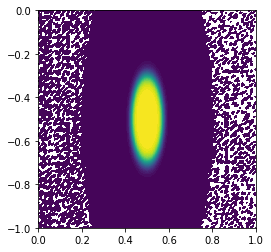

In [ ]:
plot(u)

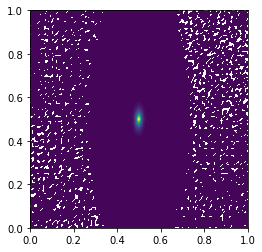

In [ ]:
uu_init = Expression(('-tanh(1/(2*0.0125)*(sqrt(2*(x[0]-0.5)*(x[0]-0.5) + 0.25*(x[1]-0.5)*(x[1]-0.5))))','0','0','0'),degree=2)
uu.interpolate(u_init)
plot(u)
vtkfile = File('deneme/solution.pvd')
vtkfile << uu.split()[0]

In [ ]:
np.tanh(0)

0.0

## Phase Field 1 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(-10, -10), Point(10,10),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L

class PeriodicBoundary(SubDomain):
    def __init__(self, tolerance=DOLFIN_EPS, length = 20.0):
        SubDomain.__init__(self)
        self.tol = tolerance
        self.length = length
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
        # return True if on left or bottom boundary AND NOT on one of the two corners (0, 1) and (1, 0)
        return bool((near(x[0], 0) or near(x[1], 0)) and 
                (not ((near(x[0], 0) and near(x[1], self.length)) or 
                        (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)

    def map(self, x, y):
        L = self.length
        if near(x[0], L) and near(x[1], L):
            y[0] = x[0] - L
            y[1] = x[1] - L
        elif near(x[0], L):
            y[0] = x[0] - L
            y[1] = x[1]
        else:   # near(x[1], 1)
            y[0] = x[0]
            y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBoundary())
# W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 1e-4
tend = 1e-1
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(0.1)
a02 = Constant(0.1)
a11 = Constant(1)
a10 = Constant(-2)
a01 = Constant(-2)
beta = Constant(2)
eps = Constant(1)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = (random.uniform(-0.2, 0.3))
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = u**3 - (1-0.025)*u
g = beta*u


f1 = (u-u0)*v1*dx - dt*dot(grad(w), grad(v1))*dx + dt/eps*g*v1*dx  
f2 = w*v2*dx - a20*eps*p.dx(0)*v2.dx(0)*dx - a02*eps*q.dx(1)*v2.dx(1)*dx  \
      -a11*eps/2*p.dx(1)*v2.dx(1)*dx - a11*eps/2*q.dx(0)*v2.dx(0)*dx  \
      -a10*eps*p*v2*dx - a01*eps*q*v2*dx + 1/eps*dfdc*v2*dx
f3 = p*v3*dx + u.dx(0)*v3.dx(0)*dx
f4 = q*v4*dx + u.dx(1)*v4.dx(1)*dx

F =  f1 + f2 + f3 + f4

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-phase-field1_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_u, _w, _p, _q = uu.split()
_u.rename("c", "concentration")
_w.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _u, _w, _p, _q = uu.split()
    _u.rename("c", "concentration")
    _w.rename("mu", "chemical potential")
    file_results.write(_u, t)
    file_results.write(_w, t)

count = 0
for t in time_array:
    if t <= 1e-2:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=1e-1:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 10000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
time = 0.0
time = 0.0001
time = 0.0002
time = 0.00030000000000000003
time = 0.0004
time = 0.0005
time = 0.0006000000000000001
time = 0.0007
time = 0.0008
time = 0.0009000000000000001
time = 0.001
time = 0.0011
time = 0.0012000000000000001
time = 0.0013000000000000002
time = 0.0014
time = 0.0015
time = 0.0016
time = 0.0017000000000000001
time = 0.0018000000000000002
time = 0.0019
time = 0.002
time = 0.0021000000000000003
time = 0.0022
time = 0.0023
time = 0.0024000000000000002
time = 0.0025
time = 0.0026000000000000003
time = 0.0027


## Phase Field 2

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 29 22:12:33 2020

@author: bilginkocak
"""
from dolfin import *
import numpy as np
import random
import time
start_time = time.time()
mesh = RectangleMesh(Point(0, 0), Point(32,32),96,96)

# define periodic bc
class PeriodicBC(SubDomain):
      def __init__(self, tolerance=DOLFIN_EPS, length = 1.0):
          SubDomain.__init__(self)
          self.tol = tolerance
          self.length = length
      def inside(self, x, on_boundary):
          return bool((near(x[0], 0) or near(x[1], 0) and on_boundary) and \
                      (not ((near(x[0], 0) and near(x[1], self.length)) or \
                      (near(x[0], self.length) and near(x[1], 0)))) and on_boundary)
      def map(self, x, y):
          L = self.length
          if near(x[0], L):
             y[0] = x[0] - L
             y[1] = x[1]
          elif near(x[1], L):  
             y[0] = x[0]
             y[1] = x[1] - L
      
P = FiniteElement("Lagrange", mesh.ufl_cell(),degree=1)
# V = FunctionSpace(mesh, "CG", 1, constrained_domain= PeriodicBC())
# P = FunctionSpace(mesh, "CG", 1)
#TH = V * P * P
TH = MixedElement([P,P,P,P])
# W = FunctionSpace(mesh, TH, constrained_domain=PeriodicBC())
W = FunctionSpace(mesh, TH)
# W = V * V * P * P
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 5

duu = TrialFunction(W)            # Incremental displacement
v1, v2, v3, v4 = TestFunctions(W)
uu = Function(W)
uu0 = Function(W)
uu00 = Function(W)
u, w, p, q = split(uu)
u0, w0, p0, q0 = split(uu0)

t = 0
dt = 1e-3
tend = 6
num = int(tend/dt) + 1
time_array = np.linspace(0,tend, num)
a20 = Constant(0.5)
a02 = Constant(0.5)
a11 = Constant(1)
a10 = Constant(-2)
a01 = Constant(-2)
beta = Constant(2)
eps = Constant(1)
M = Constant(1)

# Class representing the intial conditions
class InitialConditions(UserExpression):
    def __init__(self, **kwargs):
        random.seed(2 + MPI.rank(MPI.comm_world))
        super().__init__(**kwargs)
    def eval(self, values, x):   
        values[0] = 0.07 - 0.02*np.cos(2*np.pi*(x[0]-12)/32)*np.sin(2*np.pi*(x[1]-1)/32)  \
                  + 0.02*np.cos(np.pi*(x[0]+10)/32)**2*np.cos(np.pi*(x[1]+3)/32)**2  \
                  - 0.01*np.sin(4*np.pi*(x[0])/32)**2*np.sin(4*np.pi*(x[1]-6)/32)**2
        values[1] = 0.0
        values[2] = 0.0
        values[3] = 0.0
    def value_shape(self):
        return (4,)
# Create intial conditions and interpolate
u_init = InitialConditions(degree=1)
uu.interpolate(u_init)
uu0.interpolate(u_init)


# Compute the chemical potential df/dc
# c = variable(c)
# f    = c**4/4 - c**2/2
dfdc = u**3 - (1-0.025)*u
g = beta*u


f1 = (u-u0)*v1*dx - dt*dot(grad(w), grad(v1))*dx + dt/eps*g*v1*dx  
f2 = w*v2*dx - a20*eps*p.dx(0)*v2.dx(0)*dx - a02*eps*q.dx(1)*v2.dx(1)*dx  \
      -a11*eps/2*p.dx(1)*v2.dx(1)*dx - a11*eps/2*q.dx(0)*v2.dx(0)*dx  \
      -a10*eps*p*v2*dx - a01*eps*q*v2*dx + 1/eps*dfdc*v2*dx
f3 = p*v3*dx + u.dx(0)*v3.dx(0)*dx
f4 = q*v4*dx + u.dx(1)*v4.dx(1)*dx

F =  f1 + f2 + f3 + f4

file_results = XDMFFile("./cahn-hilliard-oono-2d/ch-phase-field2_2d.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

_u, _w, _p, _q = uu.split()
_u.rename("c", "concentration")
_w.rename("mu", "chemical potential")

def save_to_file(uu, t):
    _u, _w, _p, _q = uu.split()
    _u.rename("c", "concentration")
    _w.rename("mu", "chemical potential")
    file_results.write(_u, t)
    file_results.write(_w, t)

count = 0
for t in time_array:
    if t <= 1e-1:
      if count % 1 == 0:
        save_to_file(uu, t)
    elif t<=10:
      if count % 100 == 0:
        save_to_file(uu, t)
    else:
      if count % 1000 == 0:
        save_to_file(uu, t)
    solve(F==0, uu ,solver_parameters={"newton_solver":{"linear_solver":"lu",
                                                                        "relative_tolerance": 1e-6,
                                                                        #"preconditioner":"ilu",
                                                                        "convergence_criterion":"incremental",
                                                                        }})

    count += 1 
    print(f"time = {t}")
    uu0.assign(uu)

save_to_file(uu, t)

elapsed_time = time.time() - start_time
print("Elapsed time : " + str(elapsed_time))

time = 0.0
time = 0.001
time = 0.002
time = 0.003
time = 0.004
time = 0.005
time = 0.006
time = 0.007
time = 0.008
time = 0.009000000000000001
time = 0.01
time = 0.011
time = 0.012
time = 0.013000000000000001
time = 0.014
time = 0.015
time = 0.016
time = 0.017
time = 0.018000000000000002
time = 0.019
time = 0.02
time = 0.021
time = 0.022
time = 0.023
time = 0.024
time = 0.025
time = 0.026000000000000002
time = 0.027
time = 0.028
time = 0.029
time = 0.03
time = 0.031
time = 0.032
time = 0.033
time = 0.034
time = 0.035
time = 0.036000000000000004
time = 0.037
time = 0.038
time = 0.039
time = 0.04
time = 0.041
time = 0.042
time = 0.043000000000000003
time = 0.044
time = 0.045
time = 0.046
time = 0.047
time = 0.048
time = 0.049
time = 0.05
time = 0.051000000000000004
time = 0.052000000000000005
time = 0.053
time = 0.054
time = 0.055
time = 0.056
time = 0.057
time = 0.058
time = 0.059000000000000004
time = 0.06
time = 0.061
time = 0.062
time = 0.063
time = 0.064
time = 0.065
time = 0.066
ti

KeyboardInterrupt: ignored